# Instrument Type Classification on NSynth Dataset

## Preprocessing and Data Engineering

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import itertools
import librosa # python package for audio analysis
import keras
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
from keras.utils.vis_utils import plot_model

In [73]:
# Load JSON files
#directory to training data and json file

train = 'C:\\Users\\gpa4767\\Downloads\\nsynth-train.jsonwav.tar\\nsynth-train\\examples.json'
valid = 'C:\\Users\\gpa4767\\Downloads\\nsynth-valid.jsonwav.tar\\nsynth-valid\\examples.json'
test = 'C:\\Users\\gpa4767\\Downloads\\nsynth-test.jsonwav.tar\\nsynth-test\\examples.json'
test_dir = 'C:\\Users\\gpa4767\\Downloads\\nsynth-test.jsonwav.tar\\nsynth-test\\audio\\'
valid_dir = 'C:\\Users\\gpa4767\\Downloads\\nsynth-valid.jsonwav.tar\\nsynth-valid\\audio\\'
train_dir = 'C:\\Users\\gpa4767\\Downloads\\nsynth-train.jsonwav.tar\\nsynth-train\\audio\\'

In [27]:
#load the json files
df_train= pd.read_json(train, orient='index')
df_valid= pd.read_json(valid, orient='index')
df_test= pd.read_json(test, orient='index')
df_train.head()

,instrument,instrument_family,instrument_family_str,instrument_source,instrument_source_str,instrument_str,note,note_str,pitch,qualities,qualities_str,sample_rate,velocity
guitar_acoustic_001-082-050,39,3,guitar,0,acoustic,guitar_acoustic_001,16629,guitar_acoustic_001-082-050,82,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",[percussive],16000,50
bass_synthetic_120-108-050,881,0,bass,2,synthetic,bass_synthetic_120,168243,bass_synthetic_120-108-050,108,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",[percussive],16000,50
organ_electronic_120-050-127,979,6,organ,1,electronic,organ_electronic_120,88495,organ_electronic_120-050-127,50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],16000,127
guitar_electronic_021-026-025,346,3,guitar,1,electronic,guitar_electronic_021,146382,guitar_electronic_021-026-025,26,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]","[fast_decay, percussive]",16000,25
organ_electronic_011-079-075,188,6,organ,1,electronic,organ_electronic_011,244275,organ_electronic_011-079-075,79,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[bright],16000,75


In [29]:
df_train.describe()

,instrument,instrument_family,instrument_source,note,pitch,sample_rate,velocity
count,289205.000000,289205.000000,289205.000000,289205.000000,289205.000000,289205.0,289205.000000
mean,490.943127,3.866462,0.932370,153095.048277,62.311658,16000.0,76.172504
std,280.813189,2.843398,0.796443,88232.549732,23.082522,0.0,36.181410
min,0.000000,0.000000,0.000000,0.000000,9.000000,16000.0,25.000000
25%,247.000000,1.000000,0.000000,76755.000000,44.000000,16000.0,50.000000
50%,499.000000,4.000000,1.000000,153254.000000,62.000000,16000.0,75.000000
75%,732.000000,6.000000,2.000000,229461.000000,80.000000,16000.0,100.000000
max,1005.000000,10.000000,2.000000,305978.000000,120.000000,16000.0,127.000000


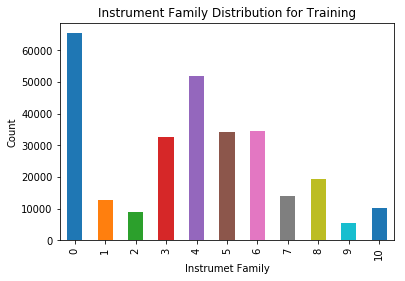

In [30]:
df_train['instrument_family'].value_counts().reindex(np.arange(0,11, 1)).plot('bar')
plt.title("Instrument Family Distribution for Training")
plt.xlabel("Instrumet Family")
plt.ylabel("Count")
plt.show()

In [31]:
df_valid.describe()

,instrument,instrument_family,instrument_source,note,pitch,sample_rate,velocity
count,12678.000000,12678.000000,12678.000000,12678.000000,12678.000000,12678.0,12678.000000
mean,435.214308,3.642530,0.843193,151895.227638,61.529894,16000.0,75.334516
std,302.248923,2.717627,0.791823,89869.132754,23.543176,0.0,35.996326
min,8.000000,0.000000,0.000000,8.000000,9.000000,16000.0,25.000000
25%,123.000000,1.000000,0.000000,72977.250000,42.000000,16000.0,50.000000
50%,417.000000,4.000000,1.000000,149368.500000,60.000000,16000.0,75.000000
75%,656.000000,6.000000,1.000000,230152.250000,80.000000,16000.0,100.000000
max,958.000000,10.000000,2.000000,305977.000000,120.000000,16000.0,127.000000


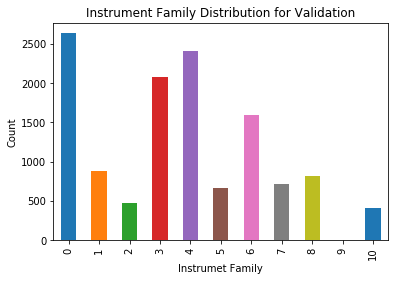

In [32]:
df_valid['instrument_family'].value_counts().reindex(np.arange(0,11, 1)).plot('bar')
plt.title("Instrument Family Distribution for Validation")
plt.xlabel("Instrumet Family")
plt.ylabel("Count")
plt.show()

In [33]:
df_test.describe()

,instrument,instrument_family,instrument_source,note,pitch,sample_rate,velocity
count,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.0,4096.000000
mean,423.497070,3.704590,0.840332,149040.895752,61.480713,16000.0,75.288574
std,300.198066,2.761171,0.799813,90014.146997,23.386504,0.0,35.775118
min,8.000000,0.000000,0.000000,87.000000,9.000000,16000.0,25.000000
25%,123.000000,1.000000,0.000000,70077.500000,42.000000,16000.0,50.000000
50%,417.000000,4.000000,1.000000,143984.500000,61.000000,16000.0,75.000000
75%,656.000000,6.000000,2.000000,228438.000000,80.000000,16000.0,100.000000
max,958.000000,10.000000,2.000000,305832.000000,119.000000,16000.0,127.000000


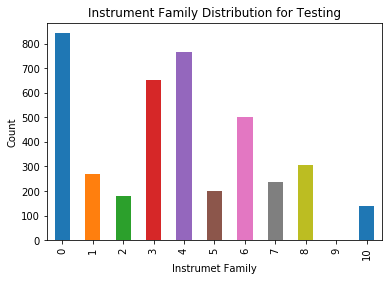

In [34]:
df_test['instrument_family'].value_counts().reindex(np.arange(0,11, 1)).plot('bar')
plt.title("Instrument Family Distribution for Testing")
plt.xlabel("Instrumet Family")
plt.ylabel("Count")
plt.show()

In [35]:
(df_train['instrument_family'] == 10).sum()

10208

In [36]:
# Instrument Family type 9 doesnt exist in validation or test set so we will drop from trianing

# Due to time and computational limitations, the training set was reduced to 2000 instances of each class to 
# reduce training time
df_train_sample=df_train.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(2000))

#drop the synth_lead from the training dataset
df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]


#save the train file index as list
filenames_train = df_train_sample.index.tolist()

#save the list to a pickle file
with open('filenames_train.pickle', 'wb') as f:
    pickle.dump(filenames_train, f)

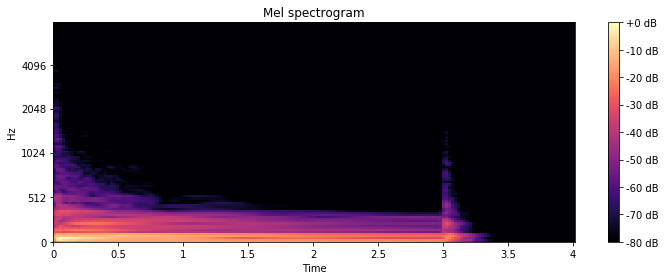

In [156]:
# Test Spectrogram
file = 'C:\\Users\\gpa4767\\Downloads\\nsynth-train.jsonwav.tar\\nsynth-train\\audio\\bass_acoustic_000-026-075.wav'
y, sr = librosa.load(file)
S = librosa.feature.melspectrogram(y=y, sr=sr)

import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [38]:
# convert wav files to spectrogram using libROSA package
def feature_extract(file):

    #get wave representation
    y, sr = librosa.load(file)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=100, hop_length=1024, fmax=8000)  
    
    return spectrogram


# extract instrument class from file name
def instrument_code(filename):
    
    class_names=['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

## Training Set

In [40]:
#create list to store all test features
list_train = []

#loop over every file in the list
for file in filenames_train:
    #extract the features
    features = feature_extract(train_dir+ file + '.wav')
    #add item to list
    list_train.append(features)

Time to extract 20000 files is 2476.510754585266 seconds


In [46]:
# reformat training data to be passed to CNN
train_X = np.stack(list_train, axis=0) # stack multiple 2d spectrograms in to 3d array
train_X = train_X.reshape(-1, 100,87, 1) # reshape array
train_X = train_X.astype('float32') # change type
train_X.shape

(20000, 100, 87)

In [50]:
# save train_X data
with open('train_X.pickle', 'wb') as f:
    pickle.dump(train_X, f)

In [58]:
# reformat training response variable to be passed to CNN
targets_train = []
for file in filenames_train:
    targets_train.append(instrument_code(file))
    
train_Y = to_categorical(targets_train, dtype='float32')
train_Y.shape

2

In [63]:
# save train_Y data
with open('train_Y.pickle', 'wb') as f:
    pickle.dump(train_Y, f)

(20000, 11)

## Validation Set

In [76]:
#save the train file index as list
filenames_valid = df_valid.index.tolist()

#save the list to a pickle file
with open('filenames_valid.pickle', 'wb') as f:
    pickle.dump(filenames_valid, f)

In [83]:
#create list to store all validation features
list_valid = []

#loop over every file in the list
for file in filenames_valid:
    #extract the features
    features = feature_extract(valid_dir+ file + '.wav') 
    #add item to list
    list_valid.append(features)

Time to extract 12678 files is 1933.580828666687 seconds


In [86]:
# reformat validation data to be passed to CNN
valid_X = np.stack(list_valid, axis=0) # stack multiple 2d spectrograms in to 3d array
valid_X = valid_X.reshape(-1, 100,87, 1) # reshape array
valid_X = valid_X.astype('float32') # change type
valid_X.shape

(12678, 100, 87)

In [87]:
# save valid_X data
with open('valid_X.pickle', 'wb') as f:
    pickle.dump(valid_X, f)

(12678, 100, 87, 1)

In [89]:
# reformat validation response variable to be passed to CNN
targets_valid = []
for file in filenames_valid:
    targets_valid.append(instrument_code(file))
    
valid_Y = to_categorical(targets_valid, dtype='float32')
valid_Y.shape

In [91]:
# save valid_Y data
with open('valid_Y.pickle', 'wb') as f:
    pickle.dump(valid_Y, f)

## Test Set

In [98]:
#save the train file index as list
filenames_test = df_test.index.tolist()

#save the list to a pickle file
with open('filenames_test.pickle', 'wb') as f:
    pickle.dump(filenames_test, f)

In [99]:
#create list to store all validation features
list_test = []

#loop over every file in the list
for file in filenames_test:
    #extract the features
    features = feature_extract(test_dir+ file + '.wav')
    #add dictionary entry
    list_test.append(features)

Time to extract 4096 files is 569.7851281166077 seconds


In [103]:
# reformat test data to be passed to CNN
test_X = np.stack(list_test, axis=0)
test_X = test_X.reshape(-1, 100,87, 1)
test_X = test_X.astype('float32')
test_X.shape

(4096, 100, 87)

In [105]:
# save test_X data
with open('test_X.pickle', 'wb') as f:
    pickle.dump(test_X, f)

In [106]:
# reformat test response variable to be passed to CNN
targets_test = []
for file in filenames_test:
    targets_test.append(instrument_code(file))
    
test_Y = to_categorical(targets_test, dtype='float32')
test_Y.shape

In [108]:
# save test_Y data
with open('test_Y.pickle', 'wb') as f:
    pickle.dump(test_Y, f)

# Define CNN

In [92]:
# CNN structure, paramters and activation fuction selection were based on previous implementations 
# outlined in the "References" section

#batch size
batch_size = 64
#number of classes
num_classes=train_Y.shape[1]
print("The number of classes is {}".format(num_classes))
#training epochs
epochs = 30
#assume we dont need data augmentation
data_augmentation = False
#where to save file
save_dir = 'NSynth'
#file name
model_name = 'nsynth_2019_06_17.h5'

print("Model saved as {}".format(model_name))

The number of classes is 11
Model saved as nsynth_2019_06_17.h5


In [93]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_X.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 87, 32)       320       
_________________________________________________________________
activation_9 (Activation)    (None, 100, 87, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 98, 85, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 98, 85, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 42, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 49, 42, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 49, 42, 64)        18496     
__________

In [95]:
# initiate ADAM optimizer
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


# Let's train the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [97]:
NSynth_train = model.fit(train_X, train_Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(valid_X, valid_Y),
          shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 12678 samples
Epoch 1/30
20000/20000 [==============================] - 1356s 68ms/step - loss: 3.0490 - acc: 0.2089 - val_loss: 2.0622 - val_acc: 0.2553
Epoch 2/30
20000/20000 [==============================] - 1092s 55ms/step - loss: 2.0091 - acc: 0.2777 - val_loss: 1.9074 - val_acc: 0.2823
Epoch 3/30
20000/20000 [==============================] - 1083s 54ms/step - loss: 1.8549 - acc: 0.3396 - val_loss: 1.7443 - val_acc: 0.3259
Epoch 4/30
20000/20000 [==============================] - 1085s 54ms/step - loss: 1.7041 - acc: 0.3966 - val_loss: 1.6968 - val_acc: 0.3356
Epoch 5/30
20000/20000 [==============================] - 1084s 54ms/step - loss: 1.5819 - acc: 0.4415 - val_loss: 1.6479 - val_acc: 0.3593
Epoch 6/30
20000/20000 [==============================] - 1083s 54ms/step - loss: 1.4888 - acc: 0.4735 - val_loss: 1.5837 - val_acc: 0.3960
Epoch 7/30
20000/20000 [==============================] - 1103

In [101]:
model.save(model_name)

## Score Model

In [109]:
# Score trained model
scores = model.evaluate(test_X, test_Y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

4096/4096 [==============================] - 42s 10ms/step
Test loss: 1.9310905542224646
Test accuracy: 0.62548828125


In [112]:
# predict response variable from test_X
pred_Y = model.predict(test_X)

In [128]:
# Reverse one hot encoding for response variable to be used for confusion matrix

pred_Y_flat = []
for i in range(0, len(pred_Y)):
    row_max = pred_Y[i].max()
    for j in range(0, len(pred_Y[0])):
        if pred_Y[i,j] == row_max:
            pred_Y_flat.append(j)
            
test_Y_flat = []
for i in range(0, len(test_Y)):
    for j in range(0, len(test_Y[0])):
        if test_Y[i,j] == 1:
            test_Y_flat.append(j)

print(len(pred_Y_flat), len(test_Y_flat))

4096 4096


In [139]:
# convert numerical class names to string class names
class_names = ['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
pred_Y_class = []
test_Y_class = []
for i in range(0, len(pred_Y_flat)):
    pred_Y_class.append(class_names[pred_Y_flat[i]])
    test_Y_class.append(class_names[test_Y_flat[i]])
    
print(len(pred_Y_class), len(test_Y_class))

4096 4096


C:\Users\gpa4767\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 0, 'Predicted label')

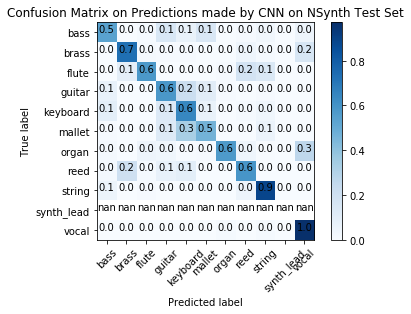

In [158]:
# Plot confusion matrix on predictions made on test set

cm = confusion_matrix(test_Y_class, pred_Y_class, labels=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Predictions made by CNN on NSynth Test Set")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
fmt = '.1f'
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')

References

Dataset - NSynth
https://magenta.tensorflow.org/datasets/nsynth#description

"Audio Classification Using CNN — An Experiment"
https://medium.com/x8-the-ai-community/audio-classification-using-cnn-coding-example-f9cbd272269e

"Audio Classification : A Convolutional Neural Network Approach"
https://github.com/CVxTz/audio_classification

"Instrument classification on the NSynth dataset using supervised learning and CNNs"
https://github.com/NadimKawwa/NSynth

"The Sequantial Model API"
https://keras.io/models/sequential/

LibROSA
https://librosa.github.io/librosa/index.html

